In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# convert the second row as the header, getting rid of !!
def convertHeader(df):
    df['GEO_ID'] = df['GEO_ID'].str[9:]
    df= df.rename(columns={'GEO_ID':'GEOID10'})
    df.columns = df.iloc[0]
    df = df.drop(index= 0).rename(columns = {"":'GEOID10'})

    cols = df.columns.tolist()
    for i in range(len(cols)):
        col = cols[i].replace( '!!',' ')
        cols[i] = col
    df.columns = cols
    return df

# find num of students of age 5-10 of each race in each block
def countElemStudents(df,race):
    elem_members = ['GEOID10','Total Male 5 to 9 years','Total Female 5 to 9 years','Total Male 10 to 14 years','Total Female 10 to 14 years']
    df_elem = df.loc[:,elem_members]
    for col in elem_members:#convert all columns to number format
        if col != 'GEOID10':
            df_elem[col] = pd.to_numeric(df_elem[col],errors = 'coerce')
    #assume kids are evenly distributed over different ages, so divide the column value by 5
    df_elem['Total Male 10 to 14 years'] = df_elem['Total Male 10 to 14 years']/5
    df_elem['Total Female 10 to 14 years'] = df_elem['Total Female 10 to 14 years']/5
    #sum over kids of all ages and genders
    df_elem['Total_{}'.format(race)] = df_elem.sum(axis = 1)
    return df_elem.loc[:,['GEOID10','Total_{}'.format(race)]]

def assignStuToSchools(block_durham, elem_durham,
                           race_column,
                           eps = 0.001):
    spatialIndex = elem_durham.sindex
    elem_durham[race_column] = 0
    for ii in block_durham.index:
        bgeom = block_durham.loc[ii,'geometry']
        possibleIndMatches = list(spatialIndex.intersection(bgeom.bounds))
        possibleMatches = elem_durham.iloc[possibleIndMatches]
        #if we only have 1 school that the kids in the block should go
        if len(possibleMatches) == 1:
            elem_durham.at[possibleIndMatches[0], race_column] += block_durham.loc[ii,race_column]
        else:
            #if we have multiple schools that the kids in the block can go
            intersectingAreas = possibleMatches.intersection(bgeom).area
            preciseMatches = possibleMatches[intersectingAreas/bgeom.area > eps]

            if len(preciseMatches) == 1:
                #if after narrowing down we have exactly one school to go
                ind = list(preciseMatches.index)[0]

                elem_durham.at[ind,race_column] += block_durham.loc[ii,race_column]

            #if we have multiple precise matches
            elif len(preciseMatches) > 1:
                totalOverlap = preciseMatches.intersection(bgeom).area.sum()
                #loop over the possible schools we can go in terms of 
                #their indices

                preciseIndMatches = preciseMatches.index
                preciseMatchAreas = preciseMatches.intersection(bgeom).area


                for idx in preciseIndMatches:
                    overlapRatio = preciseMatchAreas.loc[idx]/totalOverlap
                    stu = overlapRatio*block_durham.loc[ii,race_column]
                    elem_durham.at[idx,race_column] += int(round(stu))

            else: #in the case there is no intersection
                print('block {} students have no school to go'.format(ii))

        
            
            
    return elem_durham

In [3]:
# read the shape file for elementary school districts in Durham
elem_durham =  gpd.read_file(r'./../data/elem_durham/elem_durham.shp')
elem_durham['coords'] = elem_durham['geometry'].apply(lambda x: x.representative_point().coords[:])
elem_durham['coords'] = [coords[0] for coords in elem_durham['coords']]

In [10]:
block_durham.s

,TFID,STATEFP10,COUNTYFP10,TRACTCE10,BLKGRPCE10,BLOCKCE10,SUFFIX1CE,ZCTA5CE10,UACE10,PUMACE10,...,INTPTLAT,INTPTLON,geometry,coords,GEOID10,Total_W,Total_A,Total_M,Total_H,Total_B
0,262478920.0,37,063,001900,2,2007,None,27703,None,01302,...,+36.0056714,-78.7500381,"POLYGON ((-78.76999 35.99447, -78.76998 35.994...","(-78.74533158153845, 36.0081775)",370630019002007,1.6,0.0,0.0,1.0,0.0
1,203688956.0,37,063,001900,2,2007,None,27703,None,01302,...,+36.0037946,-78.7315713,"POLYGON ((-78.73175 36.00378, -78.73172 36.003...","(-78.73157642045454, 36.003758499999996)",370630019002007,1.6,0.0,0.0,1.0,0.0
2,203688957.0,37,063,001900,2,2007,None,27703,None,01302,...,+36.0056215,-78.7356059,"POLYGON ((-78.73592 36.00560, -78.73587 36.005...","(-78.73558245454545, 36.005652)",370630019002007,1.6,0.0,0.0,1.0,0.0
3,203689256.0,37,063,001900,2,2007,None,27703,None,01302,...,+36.0053772,-78.7660449,"POLYGON ((-78.76630 36.00527, -78.76627 36.005...","(-78.76600677614377, 36.005369)",370630019002007,1.6,0.0,0.0,1.0,0.0
4,203689567.0,37,063,001900,2,2007,None,27703,None,01302,...,+35.9928932,-78.7676335,"POLYGON ((-78.76785 35.99309, -78.76783 35.993...","(-78.7676215403896, 35.992847)",370630019002007,1.6,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9319,239051168.0,37,063,001708,1,1030,None,27704,25228,01302,...,+36.0607248,-78.8859767,"POLYGON ((-78.88633 36.06158, -78.88618 36.061...","(-78.88596020718734, 36.060733)",370630017081030,0.0,0.0,0.0,0.0,4.6
9320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,NaN,370630018015018,0.0,0.0,0.0,0.0,0.0
9321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,NaN,370630019002074,0.0,0.0,0.0,0.0,0.0
9322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,NaN,370630019002102,0.0,0.0,0.0,0.0,0.0


In [4]:
# read the shape file for the census blocks in Durham
block_durham = gpd.read_file(r'./../data/blk_shapefiles/tl_2018_37063_faces.shp')

block_durham['coords'] = block_durham['geometry'].apply(lambda x: x.representative_point().coords[:])
block_durham['coords'] = [coords[0] for coords in block_durham['coords']]
block_durham['GEOID10'] = block_durham['STATEFP10'] + block_durham['COUNTYFP10'] + block_durham['TRACTCE10'] + block_durham['BLOCKCE10']
block_durham = block_durham.dropna(subset = ['TFID'])

In [5]:
all_races = ['W','A','M','H','B']


for race in all_races:
    df_race = pd.read_csv(r'./../data/sex_age_race/sex_by_age_{}.csv'.format(race))
    df_race = convertHeader(df_race)
    df_race_elem = countElemStudents(df_race,race)
    block_durham = pd.merge(block_durham, df_race_elem, how = 'outer')

In [8]:
# write the school capacity info to data file
elem_durham['member']
f = open('school_capacity.txt', 'w')

for idx, row in elem_durham.iterrows():
    school_name = row['name']
    capacity = int(1.1*row['member'])
    write_string = school_name + '      ' + str(capacity) + "\n"
    f.write(write_string)
f.close()

# ig, ax = plt.subplots(1, 1,figsize=(25, 25))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Census Blocks in Durham",fontsize = 28)
block_durham.geometry.boundary.plot(color = None, edgecolor = 'r',linewidth = 1, ax = ax, vmin = 0, vmax = 1)

<ipython-input-6-a57c0a6c771f>:9: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=row['name'][0:12], xy=row['coords'],


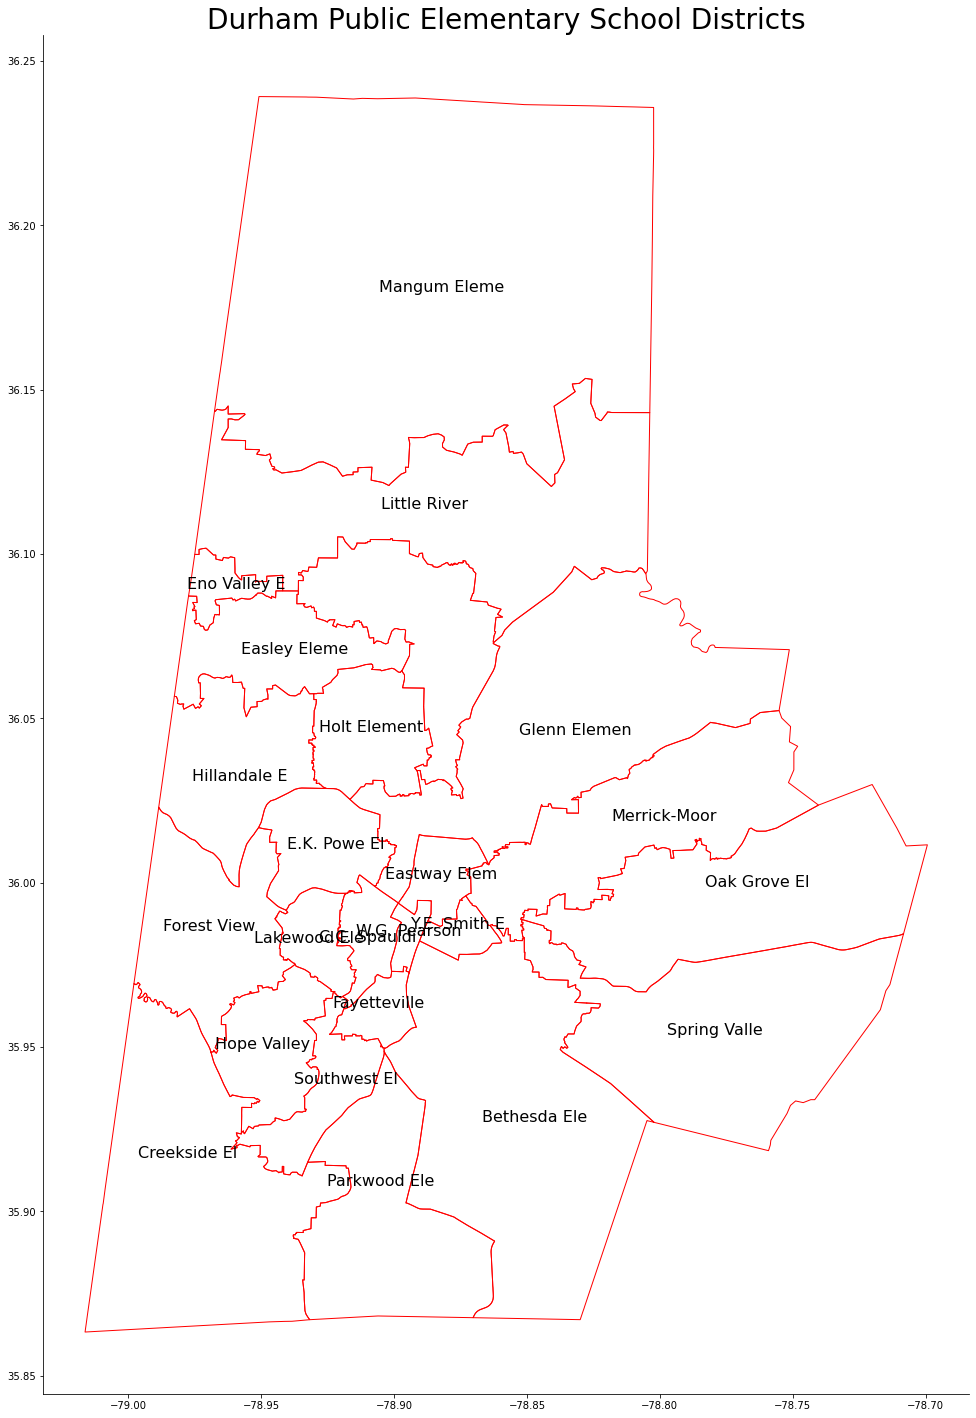

In [6]:
ig, ax = plt.subplots(1, 1,figsize=(25, 25))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Durham Public Elementary School Districts",fontsize = 28)
#elem_durham.plot(ax = ax, legend = True, column = 'Pct_H',cmap = 'YlOrRd')
#elem_durham.plot(ax = ax, legend = True,cmap = 'YlOrRd')
elem_durham.geometry.boundary.plot(color = None, edgecolor = 'r',linewidth = 1, ax = ax, vmin = 0, vmax = 1)
for idx, row in elem_durham.iterrows():
    plt.annotate(s=row['name'][0:12], xy=row['coords'],
                 horizontalalignment='center', fontsize = 16)

In [23]:
block_durham['BLKGRP10'] = block_durham['STATEFP10'] + block_durham['COUNTYFP10'] + block_durham['TRACTCE10'] +block_durham['BLKGRPCE10'] 
block_durham['TRACTID10'] =  block_durham['STATEFP10'] + block_durham['COUNTYFP10'] + block_durham['TRACTCE10']

In [24]:
df_dist =block_durham.loc[:,['GEOID10','TRACTID10','BLKGRP10']]
df_dist['LON'] = pd.to_numeric(block_durham['INTPTLON'])
df_dist['LAT'] = pd.to_numeric(block_durham['INTPTLAT'])
for index, row in elem_durham.iterrows():
    school = row['name']
    coord0 = row['coords'][0]
    coord1 = row['coords'][1]
    df_dist[school] = (df_dist['LON'] - coord0)**2 + (df_dist['LAT'] - coord1)**2  

In [25]:
df_dist = df_dist.groupby('BLKGRP10').mean()

In [26]:
df_dist

,LON,LAT,Creekside Elementary School,Easley Elementary School,Eastway Elementary School,Hope Valley Elementary School,Bethesda Elementary School,Holt Elementary Language Academy,Hillandale Elementary School,Mangum Elementary School,...,E.K. Powe Elementary School,Forest View Elementary School,Lakewood Elementary School,Little River School,C.C. Spaulding Elementary School,Fayetteville St Elementary School,Southwest Elementary School,Parkwood Elementary School,W.G. Pearson Elementary School,Spring Valley Elementary School
BLKGRP10,,,,,,,,,,,,,,,,,,,,,
370370207011,-78.947415,35.866289,0.003418,0.041438,0.022392,0.006902,0.013761,0.033767,0.027207,0.102617,...,0.021350,0.014656,0.013547,0.064656,0.014759,0.010842,0.006111,0.003516,0.016606,0.035921
370630001011,-78.887571,36.020621,0.019010,0.004917,0.000450,0.008845,0.010418,0.001128,0.005132,0.025444,...,0.001341,0.007834,0.003541,0.008697,0.002047,0.003839,0.007675,0.013072,0.001449,0.016247
370630001012,-78.883932,36.026782,0.020995,0.004722,0.000699,0.010213,0.011322,0.001016,0.005565,0.023487,...,0.001767,0.008902,0.004391,0.007604,0.002733,0.004743,0.008952,0.014635,0.001999,0.016328
370630001021,-78.902892,36.021491,0.016675,0.003549,0.000883,0.007340,0.012062,0.000678,0.003192,0.025574,...,0.000543,0.005655,0.002486,0.008748,0.001668,0.003617,0.007120,0.012973,0.001547,0.019923
370630001022,-78.901289,36.033272,0.019554,0.002689,0.001462,0.009350,0.014270,0.000285,0.003312,0.021939,...,0.001035,0.006878,0.003682,0.006694,0.002788,0.005197,0.009281,0.015822,0.002572,0.021287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371830537171,-78.801063,35.926806,0.031265,0.038960,0.012138,0.022277,0.002121,0.025771,0.035516,0.070635,...,0.021596,0.031497,0.020179,0.042560,0.014902,0.012239,0.013864,0.011183,0.011946,0.001200
371830537181,-78.758785,35.919684,0.047881,0.054355,0.021916,0.036913,0.007860,0.038407,0.052123,0.082935,...,0.034856,0.048334,0.033879,0.054455,0.026738,0.023451,0.025778,0.021549,0.022486,0.001580
371830537191,-78.758085,35.921805,0.048205,0.053973,0.021748,0.037056,0.007956,0.038085,0.051934,0.082008,...,0.034704,0.048352,0.033862,0.053818,0.026689,0.023482,0.025924,0.021808,0.022408,0.001468


In [20]:
school_string = '   '.join(list(df_dist.columns)[3:])


In [26]:
school_string = '                ' + school_string

In [57]:
school_string

'                         Creekside Elementary School   Easley Elementary School   Eastway Elementary School   Hope Valley Elementary School   Bethesda Elementary School   Holt Elementary Language Academy   Hillandale Elementary School   Mangum Elementary School   Glenn Elementary School   Eno Valley Elementary School   Merrick-Moore Elementary School   Oak Grove Elementary School   Y.E. Smith Elementary School   E.K. Powe Elementary School   Forest View Elementary School   Lakewood Elementary School   Little River School   C.C. Spaulding Elementary School   Fayetteville St Elementary School   Southwest Elementary School   Parkwood Elementary School   W.G. Pearson Elementary School   Spring Valley Elementary School'

In [63]:
import numpy as np
idx = 2
block_id = str(df_dist.iloc[idx,0]) + '                         '
dist =[str(d) for d in list(df_dist.iloc[idx,3:])]

dist_string = '   '.join(dist)
write_string =block_id + dist_string + "\n"

In [64]:
write_string

'370630001011000                         0.020680376555142495   0.005820682059798079   0.00042083031687195735   0.009995036497820797   0.009801333316435052   0.001539720728694456   0.006416403558960591   0.025336403495591   0.0028207706488729027   0.011209805660228406   0.006477206357324806   0.01385034660565529   0.0012394162617554044   0.002001902974843295   0.009318569582473592   0.004389281609497787   0.008728606146868842   0.002508163313298607   0.0042379203575117035   0.00829711259404718   0.013477757313270097   0.0016359596250135112   0.014431034881911033\n'

In [66]:
f = open('distance_file.txt', 'w')
f.write(school_string+"\n")
for idx, row in df_dist.iterrows():
    block_id = str(df_dist.iloc[idx,0]) + '              '
    dist =[str(d) for d in list(df_dist.iloc[idx,3:])]
    dist_string = '   '.join(dist)
    write_string =block_id + dist_string + "\n"
    f.write(write_string)
f.close()

In [68]:
block_durham_num = block_durham.groupby('GEOID10').sum().reset_index()

In [84]:
block_durham_num

,GEOID10,TFID,ATOTAL,Total_W,Total_A,Total_M,Total_H,Total_B
0,370370207011005,2.639054e+08,45.0,0.0,0.0,0.0,0.0,0.0
1,370370207011030,2.639054e+08,38.0,0.0,0.0,0.0,0.0,0.0
2,370630001011000,4.661742e+08,655575.0,0.8,0.0,2.8,8.8,9.2
3,370630001011001,2.036947e+08,22809.0,0.0,0.2,0.0,5.0,4.6
4,370630001011002,2.036947e+08,23209.0,0.0,0.0,0.0,2.2,1.2
...,...,...,...,...,...,...,...,...
5068,371830537171032,5.278226e+08,81.0,0.0,0.0,0.0,0.0,0.0
5069,371830537181016,1.055637e+09,1780.0,0.0,0.0,0.0,0.0,0.0
5070,371830537191006,2.639092e+08,503.0,0.0,0.0,0.0,0.0,0.0
5071,371830537192004,2.639091e+08,5273.0,0.0,0.0,0.0,0.0,0.0


In [88]:
import math
f = open('block_race_file.txt', 'w')
ethnicity_title = "            White     Asian     Multi     Hispanic     Black  :=\n"
f.write(ethnicity_title)
for idx, row in block_durham_num.iterrows():
    block_id = str(block_durham_num.iloc[idx,0]) + '              '
    nums =[int(d)+1 if d%1 > 0.5 else int(d) for d in list(block_durham_num.iloc[idx,3:])]
    nums = [str(x) for x in nums]
    nums_string = '   '.join(nums)
    write_string =block_id + nums_string + "\n"
    f.write(write_string)
f.close()